In [473]:
# 基本moduleのimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 基本moduleの設定module
plt.rcParams['font.family'] = "MS Gothic"
plt.style.use("ggplot")
sns.set_theme(context="talk", style="darkgrid", font="MS GOTHIC")

In [474]:
# 出力行数の変更
pd.set_option("display.max_rows", 100)

In [475]:
# データの読み込み
train_df = pd.read_csv("datasets/train.csv")
test_df = pd.read_csv("datasets/test.csv")
oil_df = pd.read_csv("datasets/oil.csv")
holidays_df = pd.read_csv("datasets/holidays_events.csv")
stores_df = pd.read_csv("datasets/stores.csv")
transactions_df = pd.read_csv("datasets/transactions.csv")
submission_df = pd.read_csv("datasets/sample_submission.csv")

In [476]:
# dateをdatetime型に変換
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
holidays_df["date"] = pd.to_datetime(holidays_df["date"])

**予測対象2017/8/16-2017/8/31のsalesの予測**  
### 特徴量エンジニアリングの方針
* 01_EDAから年ごとのsalesの傾向が異なることがわかったので学習は2017年のものだけで行う  
* 01_EDAから月ごとにsalesの傾向が異なるので、monthを特徴量を増やす  
* 01_EDAからfamilyはsalesに大きく影響するので平均売り上げが大きい順に数値的な大きさを持たせたdummy変数を用意する  
* 01_EDAからholidays_dfのLocal以外かつtransferred=Falseかつwork_day以外の日はsalesが大きくなることがわかっているのでその日には1をそれ以外には0を割り振る  
* dayofweekは影響がありそうだが、holidaysが移動して平日のsalesが大きくなる時もあるのでdayofweekは使わずholidaysを使う  
* 02_EDAからoil_priceはsalesとの相関が大きいので特徴量に加える  
* 02_EDAからstores_dfの'city', 'state', 'type', 'cluster'はsalesに影響するので平均売り上げが大きい順に数値的な大きさを持たせたdummy変数を用意する  
* 02_EDAからtransactionsはsalesとの相関が大きいので特徴量として使う。  
* 02_EDAからtransactionsのラグ特徴量lag1, lag2, lag3はsalesと相関があるので特徴量として使う

In [477]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [478]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [479]:
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [480]:
stores_df

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [481]:
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [482]:
# train_dfとtest_dfを結合
all_df = pd.concat([train_df, test_df], axis=0)
all_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


## categoricalな特徴量を数値に変換

### familyを平均売り上げが高い順に大きい数字に変換

In [483]:
all_df["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [484]:
# familyごとのsalesの平均をまとめたdataframeをtrain_df_familyとする
train_df_family = pd.DataFrame(train_df.groupby("family")["sales"].mean().sort_values(ascending=False))

In [485]:
train_df_family.index

Index(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY',
       'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI',
       'HOME CARE', 'EGGS', 'FROZEN FOODS', 'PREPARED FOODS',
       'LIQUOR,WINE,BEER', 'SEAFOOD', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'CELEBRATION', 'LINGERIE', 'LADIESWEAR',
       'PLAYERS AND ELECTRONICS', 'AUTOMOTIVE', 'LAWN AND GARDEN',
       'PET SUPPLIES', 'BEAUTY', 'SCHOOL AND OFFICE SUPPLIES', 'MAGAZINES',
       'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS'],
      dtype='object', name='family')

In [486]:
train_df_family.index.nunique()

33

In [487]:
family_dict = {'GROCERY I':32, 'BEVERAGES':31, 'PRODUCE':30, 'CLEANING':29, 'DAIRY':28,
       'BREAD/BAKERY':27, 'POULTRY':26, 'MEATS':25, 'PERSONAL CARE':24, 'DELI':23,
       'HOME CARE':22, 'EGGS':21, 'FROZEN FOODS':20, 'PREPARED FOODS':19,
       'LIQUOR,WINE,BEER':18, 'SEAFOOD':17, 'GROCERY II':16, 'HOME AND KITCHEN I':15,
       'HOME AND KITCHEN II':14, 'CELEBRATION':13, 'LINGERIE':12, 'LADIESWEAR':11,
       'PLAYERS AND ELECTRONICS':10, 'AUTOMOTIVE':9, 'LAWN AND GARDEN':8,
       'PET SUPPLIES':7, 'BEAUTY':6, 'SCHOOL AND OFFICE SUPPLIES':5, 'MAGAZINES':4,
       'HARDWARE':3, 'HOME APPLIANCES':2, 'BABY CARE':1, 'BOOKS':0}

In [488]:
all_df["family"] = all_df["family"].replace(family_dict).astype(int)
all_df["family"].unique()

array([ 9,  1,  6, 31,  0, 27, 13, 29, 28, 23, 21, 20, 32, 16,  3, 15, 14,
        2, 22, 11,  8, 12, 18,  4, 25, 24,  7, 10, 26, 19, 30,  5, 17])

In [489]:
# all_dfとstore_dfを結合
all_df = pd.merge(all_df, stores_df, on="store_nbr", how="left")
all_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,9,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,1,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,6,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,31,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,0,0.0,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,Quito,Pichincha,B,6
3029396,3029396,2017-08-31,9,19,NaN,0,Quito,Pichincha,B,6
3029397,3029397,2017-08-31,9,30,NaN,1,Quito,Pichincha,B,6
3029398,3029398,2017-08-31,9,5,NaN,9,Quito,Pichincha,B,6


### cityを平均売り上げが高い順に大きい数字に変換

In [490]:
# cityを数値に変換

# train_dfからstoreごとのsalesの平均を求める
sales_by_store =pd.DataFrame(train_df.groupby("store_nbr")["sales"].mean()).reset_index()
sales_by_store

# stores_dfとsales_by_storeを結合する
sales_by_store = pd.merge(stores_df, sales_by_store, on="store_nbr", how="left")
sales_by_store


# cityごとのsalesの平均
sales_at_city = pd.DataFrame(sales_by_store.groupby("city")["sales"].mean().sort_values(ascending=False)).reset_index()
sales_at_city

,city,sales
0,Quito,556.577090
1,Cayambe,509.709179
2,Ambato,362.632273
3,Daule,345.282181
4,Loja,339.379530
5,Babahoyo,319.349181
6,Machala,300.392253
7,Esmeraldas,294.963151
8,Cuenca,294.924279
9,Guayaquil,276.594464


In [491]:
sales_at_city["city"].unique()

array(['Quito', 'Cayambe', 'Ambato', 'Daule', 'Loja', 'Babahoyo',
       'Machala', 'Esmeraldas', 'Cuenca', 'Guayaquil', 'Libertad',
       'Quevedo', 'Guaranda', 'Santo Domingo', 'Ibarra', 'Salinas',
       'Riobamba', 'El Carmen', 'Latacunga', 'Playas', 'Manta', 'Puyo'],
      dtype=object)

In [492]:
sales_at_city["city"].nunique()

22

In [493]:
city_dict = {'Quito':21, 'Cayambe':20, 'Ambato':19, 'Daule':18, 'Loja':17, 'Babahoyo':16,
       'Machala':15, 'Esmeraldas':14, 'Cuenca':13, 'Guayaquil':12, 'Libertad':11,
       'Quevedo':10, 'Guaranda':9, 'Santo Domingo':8, 'Ibarra':7, 'Salinas':6,
       'Riobamba':5, 'El Carmen':4, 'Latacunga':3, 'Playas':2, 'Manta':1, 'Puyo':0}

all_df["city"] = all_df["city"].replace(city_dict).astype(int)
all_df["city"].unique()

array([21, 20,  3,  5,  7,  8,  9,  0, 19, 12,  6, 18, 16, 10,  2, 11, 13,
       17, 15, 14,  1,  4])

### stateを平均売り上げが高い順に大きい数字に変換

In [494]:
# stateを数値に変換

# stateごとのsalesの平均
sales_at_state = pd.DataFrame(sales_by_store.groupby("state")["sales"].mean().sort_values(ascending=False)).reset_index()
sales_at_state

,state,sales
0,Pichincha,554.110358
1,Tungurahua,362.632273
2,Loja,339.379530
3,El Oro,300.392253
4,Esmeraldas,294.963151
5,Azuay,294.924279
6,Los Rios,287.243342
7,Guayas,270.172671
8,Bolivar,234.821670
9,Santo Domingo de los Tsachilas,214.942315


In [495]:
sales_at_state["state"].unique()

array(['Pichincha', 'Tungurahua', 'Loja', 'El Oro', 'Esmeraldas', 'Azuay',
       'Los Rios', 'Guayas', 'Bolivar', 'Santo Domingo de los Tsachilas',
       'Imbabura', 'Santa Elena', 'Chimborazo', 'Cotopaxi', 'Manabi',
       'Pastaza'], dtype=object)

In [496]:
sales_at_state["state"].nunique()

16

In [497]:
state_dict = {'Pichincha':15, 'Tungurahua':14, 'Loja':13, 'El Oro':12, 'Esmeraldas':11, 'Azuay':10,
       'Los Rios':9, 'Guayas':8, 'Bolivar':7, 'Santo Domingo de los Tsachilas':6,
       'Imbabura':5, 'Santa Elena':4, 'Chimborazo':3, 'Cotopaxi':2, 'Manabi':1,
       'Pastaza':0}

all_df["state"] = all_df["state"].replace(state_dict).astype(int)
all_df["state"].unique()

array([15,  2,  3,  5,  6,  7,  0, 14,  8,  4,  9, 10, 13, 12, 11,  1])

### typeを平均売り上げが高い順に大きい数字に変換

In [498]:
# typeについて
store_type = pd.DataFrame(sales_by_store.groupby("type")["sales"].mean().sort_values(ascending=False)).reset_index()
store_type

,type,sales
0,A,705.878743
1,D,350.979407
2,B,326.739714
3,E,269.121301
4,C,197.263301


In [499]:
store_type["type"].unique()

array(['A', 'D', 'B', 'E', 'C'], dtype=object)

In [500]:
type_dict = {'A':4, 'D':3, 'B':2, 'E':1, 'C':0}

all_df["type"] = all_df["type"].replace(type_dict).astype(int)
all_df["type"].unique()

array([3, 0, 2, 1, 4])

### clusterを平均売り上げが高い順に大きい数字に変換

In [501]:
# clusterについて
store_cluster = pd.DataFrame(sales_by_store.groupby("cluster")["sales"].mean().sort_values(ascending=False)).reset_index()
store_cluster

,cluster,sales
0,5,1117.245254
1,14,708.227718
2,8,647.377856
3,11,603.507018
4,17,592.231511
5,6,342.661732
6,1,326.163967
7,12,324.461406
8,13,324.364108
9,4,296.572872


In [502]:
store_cluster["cluster"].unique()

array([ 5, 14,  8, 11, 17,  6,  1, 12, 13,  4,  9,  2, 10, 16, 15,  3,  7],
      dtype=int64)

In [503]:
store_cluster["cluster"].nunique()

17

In [504]:
cluster_dict = {5:16, 14:15,  8:14, 11:13, 17:12,  6:11,  1:10, 12:9, 13:8,  4:7,  9:6,  2:5, 10:4, 16:3, 15:2,  3:1,  7:0}
all_df["cluster"] = all_df["cluster"].replace(cluster_dict).astype(int)
all_df["cluster"].unique()

array([ 8,  2, 11,  0,  1,  9,  3,  6, 10,  4, 14,  5,  7, 16, 13, 15, 12])

## 特徴量エンジニアリング

In [505]:
# year, month, day_of_weekのカラムを作る
all_df["year"] = all_df.date.dt.year
all_df["month"] = all_df.date.dt.month
all_df["day_of_week"] = all_df.date.dt.dayofweek
all_df["day"] = all_df.date.dt.day
all_df["quarter"] = all_df.date.dt.quarter

In [506]:
all_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3


## Holidaysの影響を加味した特徴量の作成

In [507]:
# メタデータからtransferred=Falseでtype!='Work Day'でlocale != Localのものに注目
holidays_df_1 = holidays_df[(holidays_df["transferred"] == False) & (holidays_df["type"] != "Work Day") & (holidays_df["locale"] != "Local")]
holidays_df_1

,date,type,locale,locale_name,description,transferred
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [508]:
holidays_df_1.drop(["locale", "locale_name", "description", "transferred"], axis=1, inplace=True)
holidays_df_1

C:\Users\yuuki\AppData\Local\Temp\ipykernel_17612\2011330974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df_1.drop(["locale", "locale_name", "description", "transferred"], axis=1, inplace=True)


,date,type
1,2012-04-01,Holiday
7,2012-06-25,Holiday
14,2012-08-10,Holiday
20,2012-10-12,Transfer
21,2012-11-02,Holiday
...,...,...
345,2017-12-22,Additional
346,2017-12-23,Additional
347,2017-12-24,Additional
348,2017-12-25,Holiday


In [509]:
# 重複したrecordsを削除
holidays_df_1.drop_duplicates('date', inplace=True)
holidays_df_1

C:\Users\yuuki\AppData\Local\Temp\ipykernel_17612\1801816451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df_1.drop_duplicates('date', inplace=True)


,date,type
1,2012-04-01,Holiday
7,2012-06-25,Holiday
14,2012-08-10,Holiday
20,2012-10-12,Transfer
21,2012-11-02,Holiday
...,...,...
345,2017-12-22,Additional
346,2017-12-23,Additional
347,2017-12-24,Additional
348,2017-12-25,Holiday


In [510]:
all_df_new = pd.merge(all_df, holidays_df_1, on="date", how="left")
all_df_new

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,year,month,day_of_week,day,quarter,type_y
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,NaN
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,NaN
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,NaN
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,NaN


In [511]:
# type_xをtype, type_yをis_holidayに変更
all_df_new.rename(columns={"type_x":"type", "type_y":"is_holidays"}, inplace=True)
all_df_new

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,NaN
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,NaN
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,NaN
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,NaN


In [512]:
all_df_new["is_holidays"].unique()

array(['Holiday', nan, 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

In [513]:
# is_holidayに値が入っているものは1, Nanは0にする
is_hodidays_dict = {'Holiday':1, 'Additional':1, 'Event':1, 'Transfer':1, 'Bridge':1}
all_df_new["is_holidays"] = all_df_new["is_holidays"].replace(is_hodidays_dict)
all_df_new["is_holidays"] = all_df_new["is_holidays"].fillna(0.0)
all_df_new["is_holidays"] = all_df_new["is_holidays"].astype(int)
all_df_new["is_holidays"].unique()

array([1, 0])

In [514]:
all_df_new

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,1
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,1
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,1
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,1
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0


In [515]:
all_df_new.loc[all_df_new["sales"] == 0.0, "is_holidays"] = all_df_new["is_holidays"].replace({1:0})

In [516]:
all_df_new

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0


## oil_priceの特徴量を作成

In [517]:
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [518]:
# dcoilwticoをoil_priceに変換
oil_df.rename(columns={"dcoilwtico":"oil_price"}, inplace=True)
oil_df

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [519]:
all_df_new2 = pd.merge(all_df_new, oil_df, on="date", how="left")
all_df_new2

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0,NaN
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0,NaN
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0,NaN
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0,NaN
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0,47.26
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0,47.26


In [520]:
# salesが0の時はoil_priceのNanは0にする.
# それ以外は前後の値で補完する
all_df_new2["oil_price"] = np.where(all_df_new2["sales"] == 0, 0, all_df_new2["oil_price"].fillna(method="ffill").fillna(method="bfill").astype(float))
all_df_new2

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0,47.26
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0,47.26


## transactionsの特徴量を作成

In [521]:
transactions_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [522]:
# データフレームを結合
all_df_new3 = pd.merge(all_df_new2, transactions_df, on=["date", "store_nbr"], how="left")
all_df_new3

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,NaN
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,NaN
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,NaN
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,NaN
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0,47.26,NaN


In [523]:
# salesが0の日のtransactionsのnull値を0.0で補完
all_df_new3.loc[all_df_new3["sales"] == 0.0, "transactions"] = all_df_new3["transactions"].fillna(0.0)
all_df_new3

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,NaN
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0,47.26,NaN


In [524]:
transactions_df["store_nbr"].unique()

array([25,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39,
       40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 36, 53, 20, 29, 21,
       42, 22, 52], dtype=int64)

In [525]:
# store_nbrごとのtransactionsの平均値を求める
transactions_dict = {}
for i in transactions_df["store_nbr"].unique():
    transactions_dict[i] = transactions_df["transactions"].loc[i].mean()

In [526]:
transactions_dict

{25: 950.0,
 1: 2111.0,
 2: 2358.0,
 3: 3487.0,
 4: 1922.0,
 5: 1903.0,
 6: 2143.0,
 7: 1874.0,
 8: 3250.0,
 9: 2940.0,
 10: 1293.0,
 11: 3547.0,
 12: 1362.0,
 13: 1102.0,
 14: 2002.0,
 15: 1622.0,
 16: 1167.0,
 17: 1580.0,
 18: 1635.0,
 19: 1369.0,
 23: 1008.0,
 24: 1386.0,
 26: 708.0,
 27: 1401.0,
 28: 776.0,
 30: 2724.0,
 31: 786.0,
 32: 1691.0,
 33: 1987.0,
 34: 1587.0,
 35: 1178.0,
 37: 1385.0,
 38: 4821.0,
 39: 4208.0,
 40: 4886.0,
 41: 4161.0,
 43: 2346.0,
 44: 3077.0,
 45: 1985.0,
 46: 998.0,
 47: 1833.0,
 48: 2033.0,
 49: 3026.0,
 50: 1551.0,
 51: 1740.0,
 54: 2904.0,
 36: 915.0,
 53: 1568.0,
 20: 1381.0,
 29: 1163.0,
 21: 2605.0,
 42: 3397.0,
 22: 1038.0,
 52: 1795.0}

In [527]:
# store_nbrごとのtransactionsの平均値でそれぞれnull値を補完する
for key, value in transactions_dict.items():
    all_df_new3.loc[all_df_new3["store_nbr"] == key, "transactions"] = all_df_new3["transactions"].fillna(value)

In [528]:
all_df_new3

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions
0,0,2013-01-01,1,9,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
1,1,2013-01-01,1,1,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
2,2,2013-01-01,1,6,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
3,3,2013-01-01,1,31,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
4,4,2013-01-01,1,0,0.0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0
3029396,3029396,2017-08-31,9,19,NaN,0,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0
3029397,3029397,2017-08-31,9,30,NaN,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0
3029398,3029398,2017-08-31,9,5,NaN,9,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0


In [529]:
all_df_new3.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'year', 'month', 'day_of_week', 'day',
       'quarter', 'is_holidays', 'oil_price', 'transactions'],
      dtype='object')

In [530]:
new_order = ['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'year', 'month', 'day_of_week', 'day',
       'quarter', 'is_holidays', 'oil_price', 'transactions', 'sales']
all_df_new3 = all_df_new3[new_order]
all_df_new3

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions,sales
0,0,2013-01-01,1,9,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.0
1,1,2013-01-01,1,1,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.0
2,2,2013-01-01,1,6,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.0
3,3,2013-01-01,1,31,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.0
4,4,2013-01-01,1,0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,26,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
3029396,3029396,2017-08-31,9,19,0,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
3029397,3029397,2017-08-31,9,30,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
3029398,3029398,2017-08-31,9,5,9,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN


In [531]:
all_df_new3.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
type                0
cluster             0
year                0
month               0
day_of_week         0
day                 0
quarter             0
is_holidays         0
oil_price           0
transactions        0
sales           28512
dtype: int64

In [532]:
all_df_new3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        int32         
 4   onpromotion   int64         
 5   city          int32         
 6   state         int32         
 7   type          int32         
 8   cluster       int32         
 9   year          int32         
 10  month         int32         
 11  day_of_week   int32         
 12  day           int32         
 13  quarter       int32         
 14  is_holidays   int32         
 15  oil_price     float64       
 16  transactions  float64       
 17  sales         float64       
dtypes: datetime64[ns](1), float64(3), int32(11), int64(3)
memory usage: 288.9 MB


In [533]:
train_df_new = all_df_new3[:len(train_df)]
train_df_new

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions,sales
0,0,2013-01-01,1,9,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.000
1,1,2013-01-01,1,1,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.000
2,2,2013-01-01,1,6,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.000
3,3,2013-01-01,1,31,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.000
4,4,2013-01-01,1,0,0,21,15,3,8,2013,1,1,1,1,0,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,26,0,21,15,2,11,2017,8,1,15,3,0,47.57,2155.0,438.133
3000884,3000884,2017-08-15,9,19,1,21,15,2,11,2017,8,1,15,3,0,47.57,2155.0,154.553
3000885,3000885,2017-08-15,9,30,148,21,15,2,11,2017,8,1,15,3,0,47.57,2155.0,2419.729
3000886,3000886,2017-08-15,9,5,8,21,15,2,11,2017,8,1,15,3,0,47.57,2155.0,121.000


In [534]:
test_df_new = all_df_new3[len(train_df):].reset_index(drop=True)
test_df_new

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,year,month,day_of_week,day,quarter,is_holidays,oil_price,transactions,sales
0,3000888,2017-08-16,1,9,0,21,15,3,8,2017,8,2,16,3,0,46.80,2111.0,NaN
1,3000889,2017-08-16,1,1,0,21,15,3,8,2017,8,2,16,3,0,46.80,2111.0,NaN
2,3000890,2017-08-16,1,6,2,21,15,3,8,2017,8,2,16,3,0,46.80,2111.0,NaN
3,3000891,2017-08-16,1,31,20,21,15,3,8,2017,8,2,16,3,0,46.80,2111.0,NaN
4,3000892,2017-08-16,1,0,0,21,15,3,8,2017,8,2,16,3,0,46.80,2111.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,26,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
28508,3029396,2017-08-31,9,19,0,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
28509,3029397,2017-08-31,9,30,1,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN
28510,3029398,2017-08-31,9,5,9,21,15,2,11,2017,8,3,31,3,0,47.26,2940.0,NaN


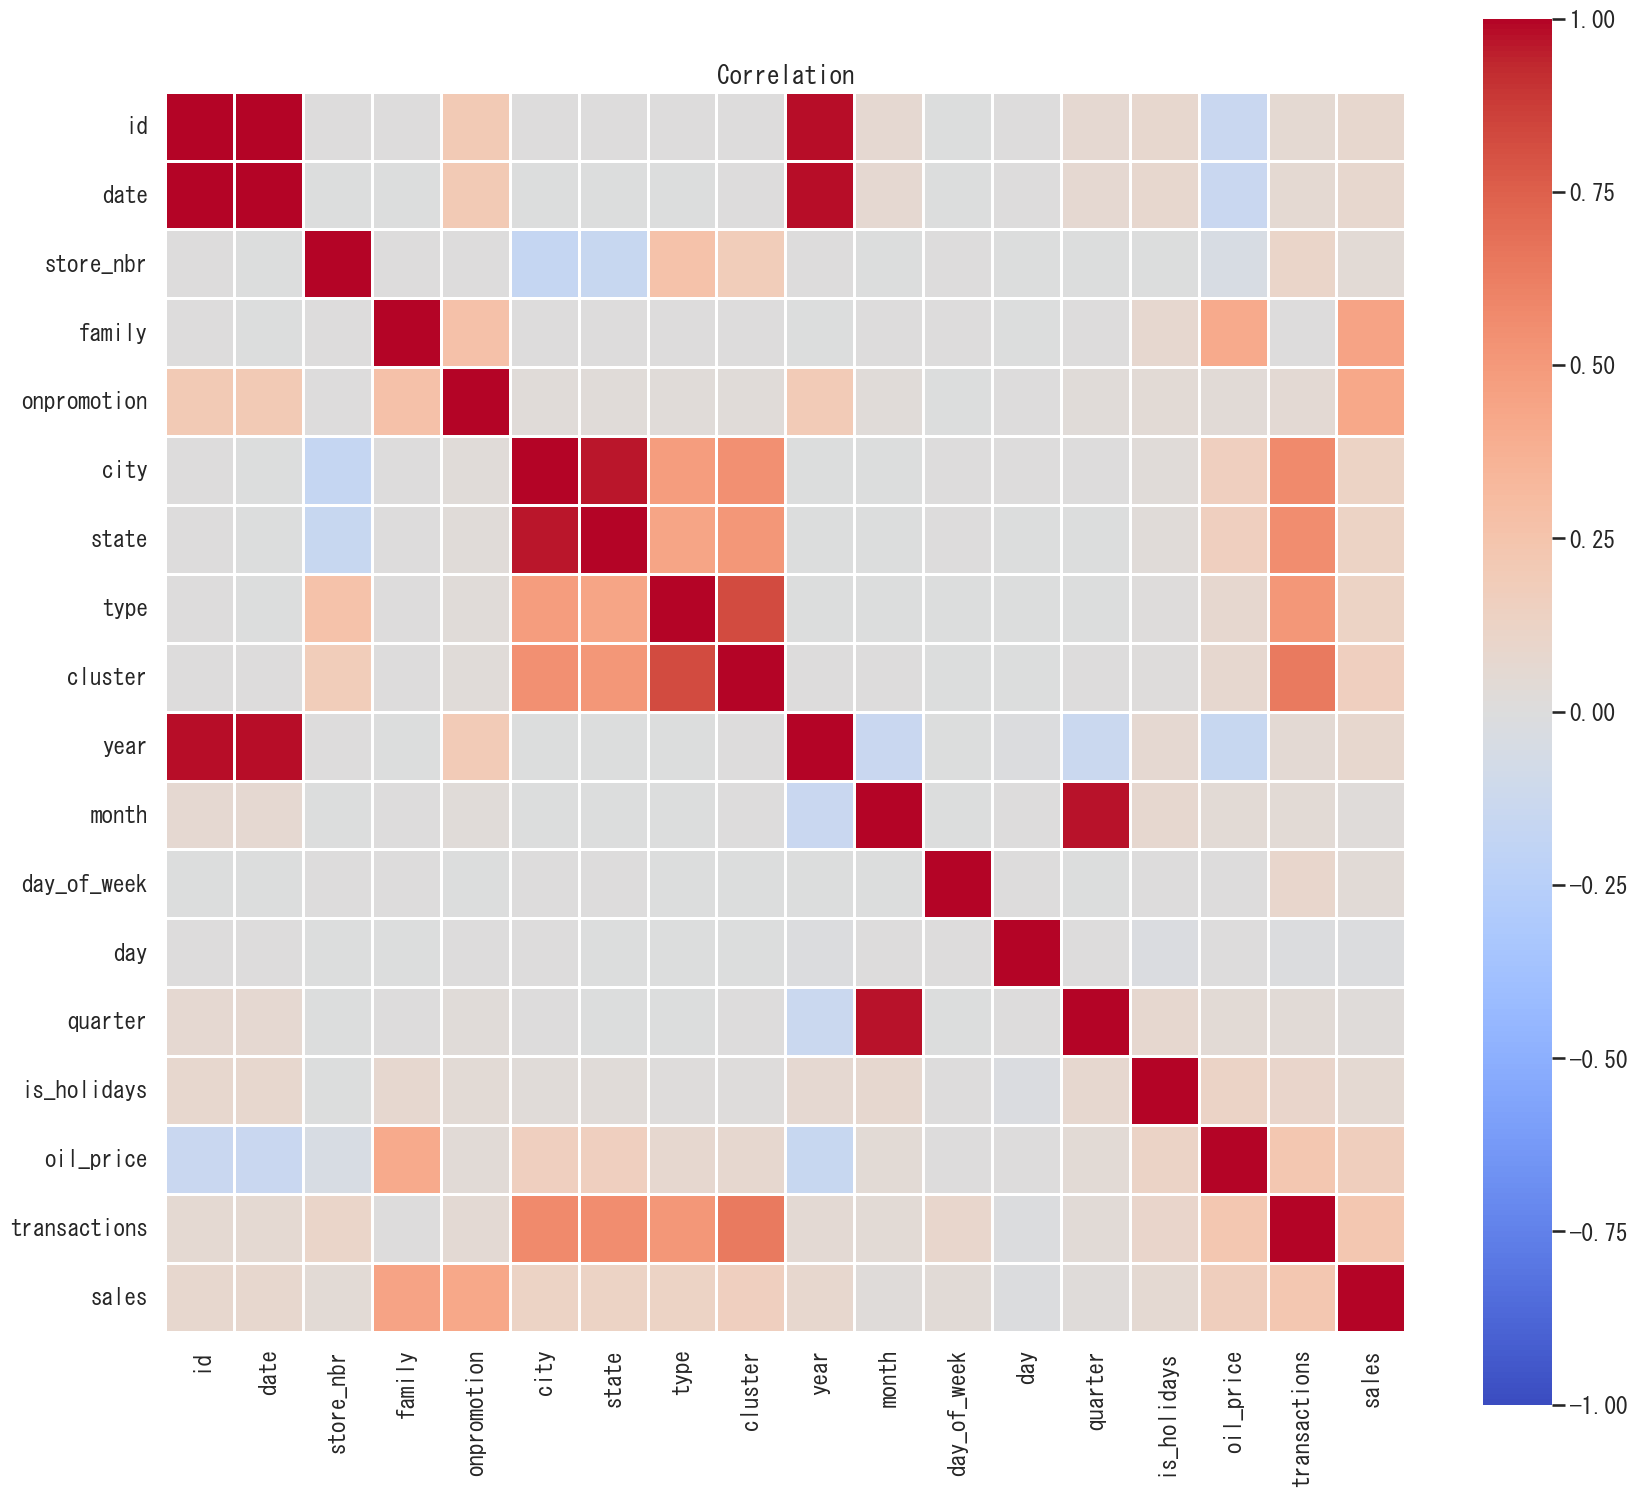

In [535]:
# train_df_newの相関関係を確認
plt.figure(figsize=(20, 18))
sns.heatmap(train_df_new.corr(), annot=False, cmap="coolwarm", square=True, linewidths=1, vmin=-1)
plt.title("Correlation")
plt.show()

In [536]:
# 説明変数同士で相関が強いものを取り除く
select_columns = ['family', 'onpromotion', 'year', 'month', 'day_of_week', 'day', 'is_holidays', 'oil_price', 'transactions', 'sales']

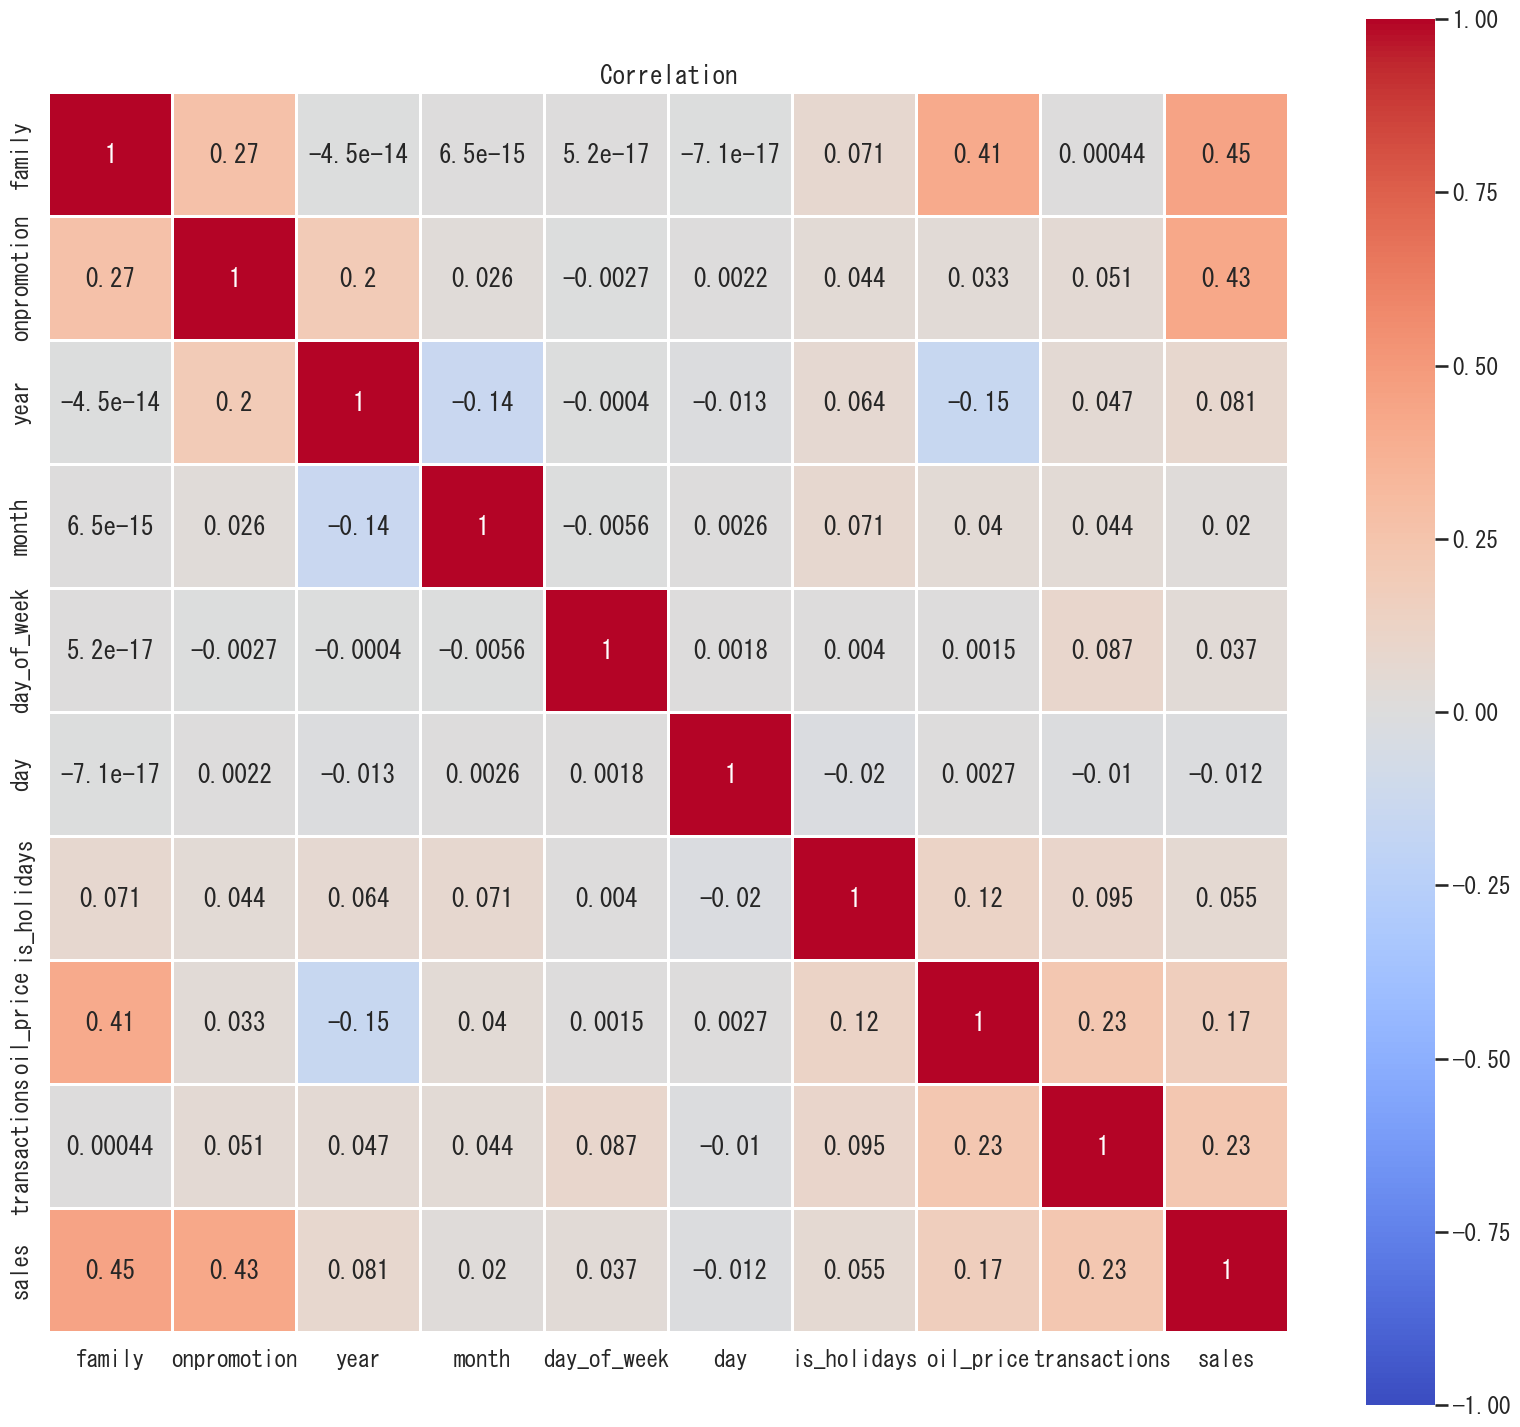

In [537]:
# train_df_newの相関関係を確認
plt.figure(figsize=(20, 18))
sns.heatmap(train_df_new[select_columns].corr(), annot=True, cmap="coolwarm", square=True, linewidths=1, vmin=-1)
plt.title("Correlation")
plt.show()

In [538]:
select_columns2 = ['id', 'date', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'day', 'is_holidays', 'oil_price', 'transactions', 'sales']

In [539]:
train_df_new2 = train_df_new[select_columns2]
train_df_new2

,id,date,family,onpromotion,year,month,day_of_week,day,is_holidays,oil_price,transactions,sales
0,0,2013-01-01,9,0,2013,1,1,1,0,0.00,0.0,0.000
1,1,2013-01-01,1,0,2013,1,1,1,0,0.00,0.0,0.000
2,2,2013-01-01,6,0,2013,1,1,1,0,0.00,0.0,0.000
3,3,2013-01-01,31,0,2013,1,1,1,0,0.00,0.0,0.000
4,4,2013-01-01,0,0,2013,1,1,1,0,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,26,0,2017,8,1,15,0,47.57,2155.0,438.133
3000884,3000884,2017-08-15,19,1,2017,8,1,15,0,47.57,2155.0,154.553
3000885,3000885,2017-08-15,30,148,2017,8,1,15,0,47.57,2155.0,2419.729
3000886,3000886,2017-08-15,5,8,2017,8,1,15,0,47.57,2155.0,121.000


In [540]:
test_df_new2 = test_df_new[select_columns2].drop("sales", axis=1)
test_df_new2

,id,date,family,onpromotion,year,month,day_of_week,day,is_holidays,oil_price,transactions
0,3000888,2017-08-16,9,0,2017,8,2,16,0,46.80,2111.0
1,3000889,2017-08-16,1,0,2017,8,2,16,0,46.80,2111.0
2,3000890,2017-08-16,6,2,2017,8,2,16,0,46.80,2111.0
3,3000891,2017-08-16,31,20,2017,8,2,16,0,46.80,2111.0
4,3000892,2017-08-16,0,0,2017,8,2,16,0,46.80,2111.0
...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,26,1,2017,8,3,31,0,47.26,2940.0
28508,3029396,2017-08-31,19,0,2017,8,3,31,0,47.26,2940.0
28509,3029397,2017-08-31,30,1,2017,8,3,31,0,47.26,2940.0
28510,3029398,2017-08-31,5,9,2017,8,3,31,0,47.26,2940.0


In [541]:
# 保存
train_df_new2.to_csv("processed/train_pr.csv", index=False)
test_df_new2.to_csv("processed/test_pr.csv", index=False)